# Analyze output of .hdf5 files of hadrons code
June 12, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools

In [3]:
import gvar as gv
import h5py

In [4]:
%matplotlib notebook

m_f = 0.02 \
Want m_res < 10^-3

$ m_{phys} = m_f + m_{res} $ 

In [5]:
#  ## Code to explore hdf5 data
# def get_ds_dictionaries(name, node):
  
#     fullname = node.name
#     if isinstance(node, h5py.Dataset):
#     # node is a dataset
#         print(f'Dataset: {fullname}; adding to dictionary')
#         ds_dict[fullname] = node[:]
#         print('ds_dict size', len(ds_dict)) 
#     else:
#      # node is a group
#         print(f'Group: {fullname}; skipping')  
    
    
# ds_dict= {}    
# with h5py.File(output_dir+f1) as hf:
#     print(hf.visititems(get_ds_dictionaries))
# print(ds_dict)

# ds_dict= {}    
# with h5py.File(output_dir+f2) as hf:
#     print(hf.visititems(get_ds_dictionaries))
# print(ds_dict)


In [6]:
## Modules

def f_extract_meson(fname,meson_dict):
    
    with h5py.File(fname) as hf:
        meson_dict['corr']=np.asarray(hf['meson']['meson_0']['corr'][:].tolist())

    return meson_dict

def f_extract_wi(fname,wi_dict):
    
    with h5py.File(fname) as hf:
        for key1,value1 in hf['wardIdentity'].items():
            wi_dict[key1]=np.array(hf['wardIdentity'][key1][:].tolist())

    return wi_dict
    
    
def f_compute_mresidual(meas_dict):
    arr=np.array([i[0]/j[0] for i,j in zip(meas_dict['PJ5q'],meas_dict['meson_corr'])])

    return arr

def f_extract_wilson_flow(fname):
    
    keys=['flow_time','Plaq_density','Clover_density','top_charge','plaq','rect','r_ploop','i_ploop']
    flow_vars=dict.fromkeys(keys)

    with h5py.File(fname) as hf:
        for idx,key in enumerate(keys):
#             print(type(hf['FlowObservables']['FlowObservables_%s'%(idx)]['data']))
            flow_vars[key]=np.array(hf['FlowObservables']['FlowObservables_%s'%(idx)]['data'])
    
    return flow_vars


In [7]:

def f_get_meas(run_dir,epoch,drop_imag=True):
    
    f1='eta_s_2pt.{0}.h5'.format(epoch)
    f2='prop_gauge_DWF.{0}.h5'.format(epoch)

    meson_dict={}
    meson_dict=f_extract_meson(run_dir+f1,meson_dict)

    wi_dict={}
    wi_dict=f_extract_wi(run_dir+f2,wi_dict)
    
    ## Copy each element of wi_dict into meas_dict
    meas_dict=dict(wi_dict)
    
    meas_dict['meson_corr']=meson_dict['corr']
    
    m_res=f_compute_mresidual(meas_dict)
    meas_dict['m_res']=m_res
    
    if drop_imag==True:# Drop imaginary part
        for key in meas_dict.keys():
            if key!='m_res':
                meas_dict[key]=meas_dict[key][:,0]
    
    return meas_dict


def f_plot_mres(meas_dict,plot_ensemble=True,plot_corr=True):
    
    ## Plot correlators
#     if imag_part=True: 
#         y1=[i[0] for i in meas_dict['PJ5q']]
#         y2=[i[0] for i in meas_dict['meson_corr']]
    
    
    y1=meas_dict['PJ5q']
    y2=meas_dict['meson_corr']
    x=np.arange(y1.shape[0])

    if plot_corr: 
        plt.figure()
        if plot_ensemble: 
            plt.errorbar(x,gv.mean(y1),gv.sdev(y1),linestyle='',marker='*',label='Axial')
            plt.errorbar(x,gv.mean(y2),gv.sdev(y2),linestyle='',marker='o',label='meson')

        else: 
            plt.plot(x,y1,linestyle='',marker='*',label='Axial')
            plt.plot(x,y2,linestyle='',marker='o',label='meson')

        plt.yscale('log')
        plt.ylabel('correlator')
        plt.legend()
    
    
    ## Plot residual mass
    plt.figure()
    if plot_ensemble: 
        plt.errorbar(x,gv.mean(meas_dict['m_res']),gv.sdev(meas_dict['m_res']),linestyle='',marker='*')
    else: 
        plt.plot(x,meas_dict['m_res'],linestyle='',marker='*')
    plt.ylabel("residual mass")


In [17]:
def f_get_meas_ensemble(run_dir,epoch_list,imag_part=False):
    
    lst=[]
    for epoch in epoch_list:
        lst.append(f_get_meas(run_dir,epoch))
    
    keys = lst[0].keys()
    avg_dict={}
    
    for key in keys: 
        if (imag_part==True and key!='m_res'): # If input has imaginary part in array, extract real part
            a1=np.array([i[key][:,0]for i in lst])
        else: 
            a1=np.array([i[key] for i in lst])
            
            
        lgth=a1.shape[1]
        # Average over samples for each t-correlator
        avg_dict[key]=np.array([gv.dataset.avg_data(a1[:,i]) for i in range(lgth)])
    
    return avg_dict


def f_wflow_ensemble(flist,wf_time=90,var='plaq'):
    '''
    Get Wilson flow observables for fixed flow time
    Can plot variation vs epoch
    '''
    
    obs_list=['flow_time', 'Plaq_density', 'Clover_density', 'top_charge', 'plaq', 'rect', 'ploop']
    assert var in obs_list, "Obsevable %s not in vars list %s"%(var,obs_list)
    
    cols=obs_list+['epoch']
    df=pd.DataFrame(columns=cols)
    
    dict1={}
    avg_dict={}
    
    for count,fname in enumerate(flist):
        flow_vars=f_extract_wilson_flow(fname)
        
        dict1['epoch']=int(fname.split('/')[-1].split('.')[1])
        # Get values at fixed Wilsonflow time

        for key in obs_list:
#             print(key)
            if not key.endswith('ploop'):
                dict1[key] = np.array(flow_vars[key])[wf_time]
            else : 
                dict1[key] = np.array([complex(i,j) for i,j in zip(flow_vars['r_ploop'],flow_vars['i_ploop'])])[wf_time]
    
#         print(dict1)
        ## Append to Dataframe
        df=pd.concat([df,pd.DataFrame(dict1,index=[df.shape[0]+1])])

    return df
    

def f_plot(df,obs):
    '''
    Plot variation with epoch for given observables
    For polyakov loop, also make scatter plot along with absolute value plot
    '''
    
    x=df.epoch.values
    y=df[obs].values

    if obs=='ploop':
        plt.figure()
        plt.scatter(y.real,y.imag,marker='H')
        plt.xlabel('real part')
        plt.ylabel('imag part')
        plt.show()
        
    plt.figure()
    if obs=='ploop':  y=np.abs(y)
    
    plt.plot(x,y,linestyle='',marker='*')
    plt.xlabel('epoch')
    plt.title(obs)
    plt.show()
    
    
def f_avg_obs(df):
    
    dict1={}
    for col in df.columns:
        if col =='ploop':
            dict1['mag_ploop']=gv.dataset.avg_data(np.abs(df[col].values))
            dict1['ploop']    =[gv.dataset.avg_data(np.real(df[col])),gv.dataset.avg_data(np.imag(df[col]))]
        elif col in ['flow_time','epoch']:
            pass
        else : 
            dict1[col] =gv.dataset.avg_data(df[col].values)
            
            
    return dict1


## 1.Plot single mesurement

In [18]:
top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_4_test_new_wflow/'

run_dir=glob.glob(top_dir+'meas_run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1/*-tioga')[0]+'/'
print(run_dir)

/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_4_test_new_wflow/meas_run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1/081723_020642-tioga/


### Plot mres

<IPython.core.display.Javascript object>


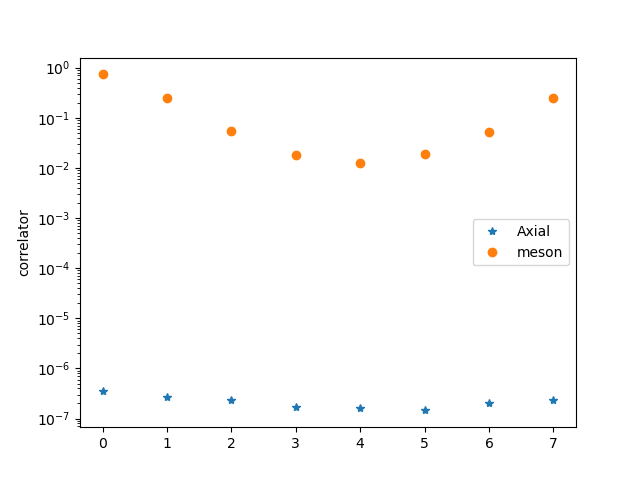

<IPython.core.display.Javascript object>


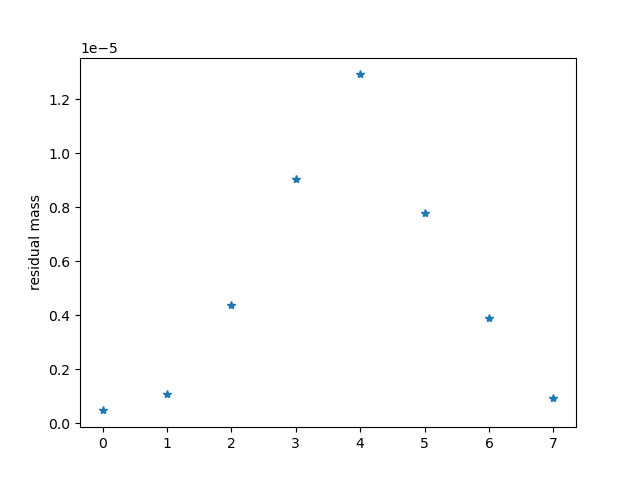

In [19]:
run_dir=top_dir+'meas_run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1/081723_020642-tioga/'

for epoch in [240]:
    m1=f_get_meas(run_dir,epoch,True)
    f_plot_mres(m1,False)
    plt.show()

### Wilson flow

In [20]:
epoch=600
fname=top_dir+'meas_run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1/081723_020642-tioga/Wflow_.{0}.h5'.format(epoch)
print(fname)

/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_4_test_new_wflow/meas_run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1/081723_020642-tioga/Wflow_.600.h5


In [21]:
flow_vars=f_extract_wilson_flow(fname)

<IPython.core.display.Javascript object>


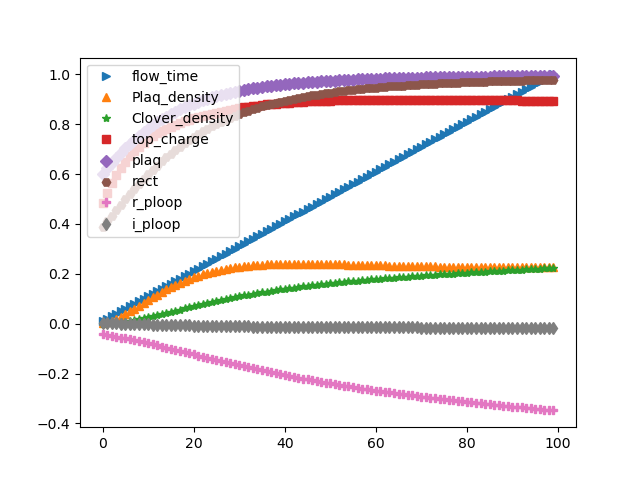

In [22]:
# Plot Wilson flow results

keys=['flow_time','Plaq_density','Clover_density','top_charge','plaq','rect','r_ploop','i_ploop']

plt.figure()
for key,marker in zip(keys,itertools.cycle('>^*sDHPdpx_')):
    plt.plot(flow_vars[key],linestyle='',marker=marker,label=key)
    
plt.legend(loc='best')

## 2. Plot ensemble

### mres

<IPython.core.display.Javascript object>


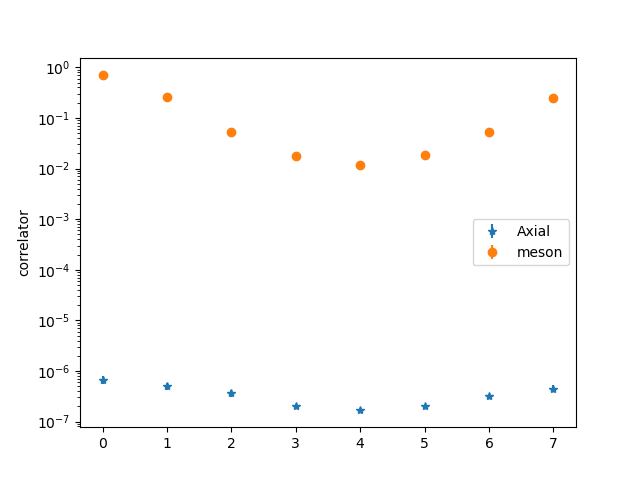

<IPython.core.display.Javascript object>


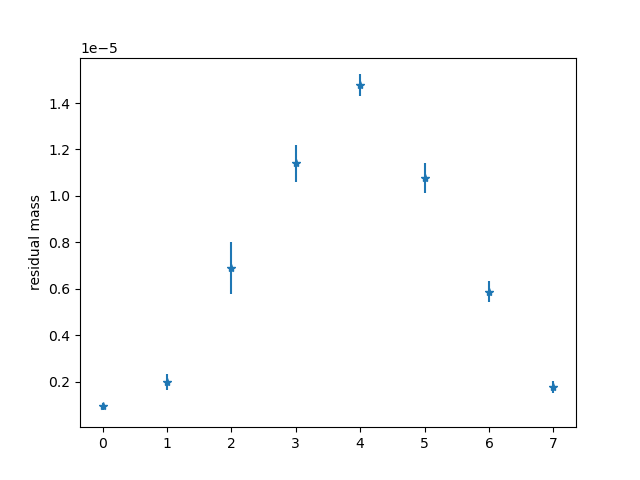

In [23]:
epoch_list=[i.split('/')[-1].split('.')[1] for i in glob.glob(run_dir+'eta_*')]
avg_dict=f_get_meas_ensemble(run_dir,epoch_list)
f_plot_mres(avg_dict,plot_ensemble=True,plot_corr=True)


## Wilson flow

In [24]:
flist=glob.glob(run_dir+'Wflow*')

df_epoch=f_wflow_ensemble(flist,90,'ploop')

df_epoch

,flow_time,Plaq_density,Clover_density,top_charge,plaq,rect,ploop,epoch
1,0.91,0.237504,0.226845,3.197820,0.992033,0.973087,-0.158611-0.012097j,200
2,0.91,0.232181,0.221436,2.369344,0.992212,0.973705,-0.189044+0.013211j,240
3,0.91,0.228498,0.217471,1.468420,0.992335,0.974145,-0.282532-0.001391j,280
4,0.91,0.227411,0.216145,1.646567,0.992372,0.974283,-0.295852+0.013669j,320
5,0.91,0.226727,0.214627,1.722177,0.992395,0.974410,-0.298112-0.011593j,360
6,0.91,0.233143,0.221831,1.507932,0.992179,0.973626,-0.311349+0.022809j,400
7,0.91,0.230803,0.219703,0.718267,0.992258,0.973882,-0.328188+0.017206j,440
8,0.91,0.220758,0.209183,0.839599,0.992595,0.975068,-0.378839-0.014692j,480
9,0.91,0.226883,0.215251,0.878205,0.992389,0.974365,-0.297745+0.013219j,520
10,0.91,0.223665,0.211485,0.778090,0.992497,0.974766,-0.386562+0.005786j,560


<IPython.core.display.Javascript object>


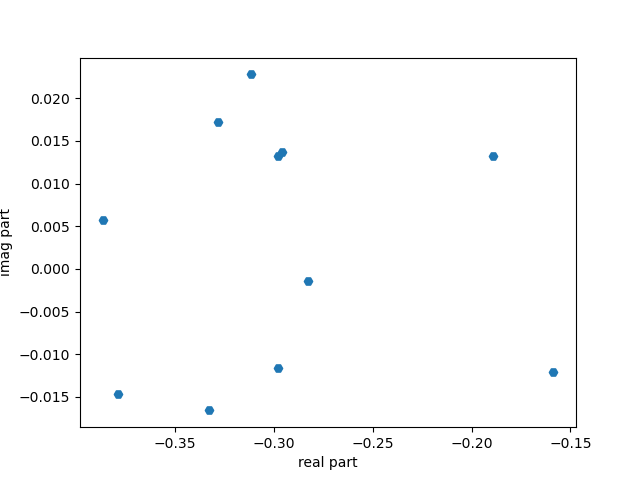

<IPython.core.display.Javascript object>


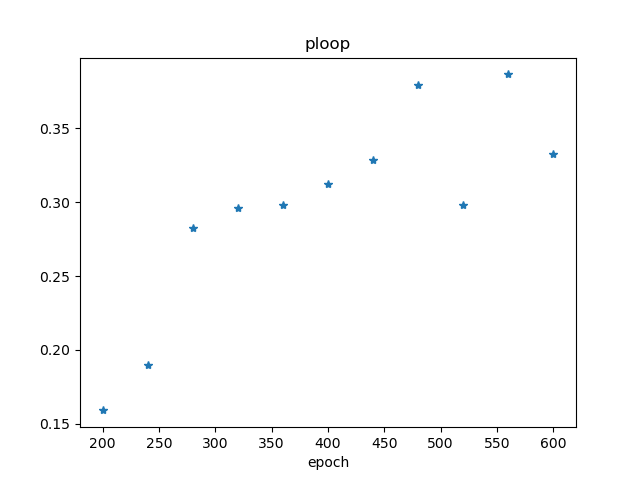

<IPython.core.display.Javascript object>


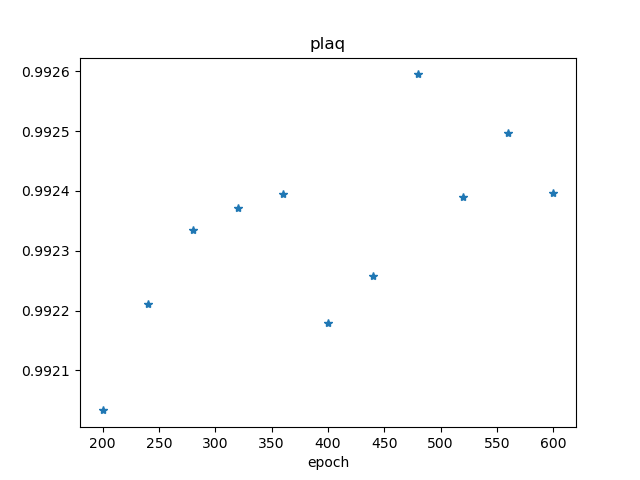

In [25]:
f_plot(df_epoch,'ploop')
f_plot(df_epoch,'plaq')


In [26]:
## Get average over epochs
d_avg=f_avg_obs(df_epoch)
print(d_avg)

{'Plaq_density': 0.2286(13), 'Clover_density': 0.2172(14), 'top_charge': 1.46(22), 'plaq': 0.992333(45), 'rect': 0.97416(16), 'mag_ploop': 0.297(20), 'ploop': [-0.296(20), 0.0027(41)]}
